# OCR Projet 6 - Anticipez les besoins en consommation de bâtiments

# Partie 2 : Modélisation 

## 1.  Import des modules 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import missingno as msno
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import cross_val_score
import shap
import plotly.io as pio
pio.renderers.default = "iframe_connected"


print(f"Pandas      : {pd.__version__}")
print(f"Numpy       : {np.__version__}")
print(f"Seaborn     : {sns.__version__}")
print(f"Plotly      : {plotly.__version__}")
print(f"Missingno   : {msno.__version__}")
print(f"StandardScaler : {StandardScaler}")
print("SHAP version:", shap.__version__)

c:\Users\mathi\OneDrive\Documents\8_OCR\Projet_6\projet6_folder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pandas      : 2.3.3
Numpy       : 2.3.4
Seaborn     : 0.13.2
Plotly      : 6.4.0
Missingno   : 0.5.2
StandardScaler : <class 'sklearn.preprocessing._data.StandardScaler'>
SHAP version: 0.50.0


In [7]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from category_encoders.binary import BinaryEncoder

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


## 2. Preprocessing

A déjà été réalisé dans l'analyse exploration : 
* Suppression de toutes les colonnes peu pertinentes pour la modélisation. 
* Tracer la distribution de la cible
* Suppression des outliers (Z) 
* Suppression des features redondantes en utilisant une matrice de corrélation
* Réalisation différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots)

### 2.1 Séparation du  jeu de données features et targets 

In [8]:
df_building_clean = pd.read_csv('data/building_clean.csv')

In [9]:
df_building_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PrimaryPropertyType     1292 non-null   object 
 1   Latitude                1292 non-null   float64
 2   Longitude               1292 non-null   float64
 3   YearBuilt               1292 non-null   int64  
 4   NumberofFloors          1292 non-null   int64  
 5   PropertyGFAParking      1292 non-null   int64  
 6   PropertyGFABuilding(s)  1292 non-null   int64  
 7   SiteEnergyUse(kBtu)     1292 non-null   float64
 8   TotalGHGEmissions       1292 non-null   float64
 9   pct_electricity         1292 non-null   float64
 10  pct_steam               1292 non-null   float64
 11  has_parking             1292 non-null   bool   
dtypes: bool(1), float64(6), int64(4), object(1)
memory usage: 112.4+ KB


 targets : consommation des bâtiments

In [10]:
y = df_building_clean['SiteEnergyUse(kBtu)']

je passe au log pour Le log réduit l’effet des valeurs extrêmes et rend la distribution plus symétrique, ce qui facilite l’apprentissage.

In [11]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1292 entries, 0 to 1291
Series name: SiteEnergyUse(kBtu)
Non-Null Count  Dtype  
--------------  -----  
1292 non-null   float64
dtypes: float64(1)
memory usage: 10.2 KB


 features

In [12]:
features = df_building_clean.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']).columns.tolist()
features

## A un meilleur score si on enlève les parkings : j'enleve ? 

# features = ['PrimaryPropertyType',
#     'Latitude',
#     'Longitude',
#     'YearBuilt',
#     'NumberofFloors',
#     'PropertyGFABuilding(s)',
#     'pct_electricity',
#     'pct_steam']

['PrimaryPropertyType',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'pct_electricity',
 'pct_steam',
 'has_parking']

In [13]:
X = df_building_clean[features]

### 2.2 Encodage variable catégorielle

In [14]:
df_building_clean['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Office              383
Other               342
Warehouse           233
Retail              117
Education            83
Worship Facility     66
Hospitality          54
Healthcare           14
Name: count, dtype: int64

J'ai 8 catégories dans PrimaryPropertyType.

*Choix méthode d'encodage* : Pour encoder la variable catégorielle, LabelEncoder met un nombre à chaque catégorie, ce qui crée une hiérarchie implicite, alors que One-Hot crée une colonne pour chaque catégorie sans ordre.
On choisit One-Hot parce que nos types de bâtiments n’ont pas d’ordre, donc on évite de tromper le modèle.

In [15]:
# Utilisation de pd.get_dummies
X = pd.get_dummies(X, columns=['PrimaryPropertyType'], drop_first=True) 

# drop_first=True pour éviter la colinéarité
print(X.head())

   Latitude  Longitude  YearBuilt  NumberofFloors  PropertyGFAParking  \
0  47.61220 -122.33799       1927              12                   0   
1  47.61317 -122.33393       1996              11               15064   
2  47.61412 -122.33664       1926              10                   0   
3  47.61623 -122.33657       1999               2               37198   
4  47.61390 -122.33283       1926              11                   0   

   PropertyGFABuilding(s)  pct_electricity  pct_steam  has_parking  \
0                   88434         0.546060   0.277302        False   
1                   88502         0.386609   0.000000         True   
2                   61320         0.407519   0.325913        False   
3                   60090         0.609884   0.000000         True   
4                   83008         0.488160   0.000000        False   

   PrimaryPropertyType_Healthcare  PrimaryPropertyType_Hospitality  \
0                           False                             True   


One-Hot crée une colonne par catégorie (-1 pour la derniere colonne) On a donc 7 colonnes de plus. C'est raisonnable car on a un petit panel mais on peut essayer l'**encodage binaire** avec la librairy category_encoders.

#### Test binaryEncoder

In [16]:


encoder = BinaryEncoder(cols=['PrimaryPropertyType'], return_df=True)
X_binary_encoded = encoder.fit_transform(df_building_clean)
X_binary_encoded.head()

,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,pct_electricity,pct_steam,has_parking
0,0,0,0,1,47.61220,-122.33799,1927,12,0,88434,7226362.5,249.98,0.546060,0.277302,False
1,0,0,0,1,47.61317,-122.33393,1996,11,15064,88502,8387933.0,295.86,0.386609,0.000000,True
2,0,0,0,1,47.61412,-122.33664,1926,10,0,61320,6794584.0,286.43,0.407519,0.325913,False
3,0,0,1,0,47.61623,-122.33657,1999,2,37198,60090,12086616.0,301.81,0.609884,0.000000,True
4,0,0,0,1,47.61390,-122.33283,1926,11,0,83008,5758795.0,176.14,0.488160,0.000000,False


Cette méthode d’encodage est moins lisible, donc je préfère rester sur la première méthode, qui est plus claire et suffisante vu la petite taille de mes données.

### 2.3 Train-test split

Train test split 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2 , random_state = 42)

In [18]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)

### 2.4 Normalisation : mettre à la même échelle 

La normalisation rend chaque variable comparable (moyenne = 0, écart-type = 1).

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)


## 3. Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

Mon objectif est de prédire les consommations d'énergies : Expliquer/prédire une variable cible. La régression linéaire réponds à cet objectif

### 3.1 fonctions 

In [20]:
def evaluate_to_df(model,X_test, y_test, y_pred_test, model_name="Model"):

    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = model.score(X_test, y_test)

    # R2 en validation croisée : R² CV = performance moyenne sur plusieurs tests
    r2_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    r2_cv_mean = r2_cv_scores.mean()

    # Création du DataFrame
    results_df = pd.DataFrame([{
        "Model": model_name,
        "MAE (M kBtu)": round(mae / 1_000_000, 2),
        "RMSE (M kBtu)": round(rmse / 1_000_000, 2),
        "R2": round(r2, 3),
        f"R2 CV (5-fold)": round(r2_cv_mean, 3)
    }])

    return results_df


In [21]:
def evaluate(X_test, y_test, y_pred_test):
    # MAE
    mae = mean_absolute_error(y_test, y_pred_test)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    # R2
    r2 = lin_reg.score(X_test, y_test)


    # Affichage en millions
    print(f"MAE test: {mae / 1_000_000:.2f} M kBtu")
    print(f"RMSE test: {rmse / 1_000_000:.2f} M kBtu")
    print(f"R2 test: {r2:.3f}\n")

    # MAE - Erreur Absolue Moyenne
    print(f"L'erreur absolue moyenne (MAE) est de  {mae:.0f} unités (kBtu) sur le test.")
    print(f"→ Le modèle se trompe en moyenne de  {mae:.0f} unités (kBtu) sur le test.")
    print()


    # RMSE - Racine de l'Erreur Quadratique Moyenne
    print(f"RMSE : L'écart-type des erreurs est de  {rmse:.2f} unités sur le test.")
    print()

    # R² - Coefficient de détermination
    print(f"R² : Le coefficient de détermination est de  {r2:.3f} sur le test.")
    print(f"→ Le modèle explique {r2*100:.1f}% sur le test.")
    print()

    print('_' * 50)


### 3.2 Regression linéaire

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Cela signifit que le modèle explique environ 50 % de la variance de la variable cible — donc il capte une partie du signal, mais il y a encore presque la moitié qui lui échappe.

je prédit y en fonction des données X_train 

In [23]:
y_pred_test = lin_reg.predict(X_test)
df_results_lr = evaluate_to_df(lin_reg, X_test, y_test, y_pred_test, model_name="LinearRegression")
df_results_lr

,Model,MAE (M kBtu),RMSE (M kBtu),R2,R2 CV (5-fold)
0,LinearRegression,1.65,2.48,0.461,0.453


In [24]:
evaluate(X_test, y_test, y_pred_test)

MAE test: 1.65 M kBtu
RMSE test: 2.48 M kBtu
R2 test: 0.461

L'erreur absolue moyenne (MAE) est de  1650741 unités (kBtu) sur le test.
→ Le modèle se trompe en moyenne de  1650741 unités (kBtu) sur le test.

RMSE : L'écart-type des erreurs est de  2476233.00 unités sur le test.

R² : Le coefficient de détermination est de  0.461 sur le test.
→ Le modèle explique 46.1% sur le test.

__________________________________________________


In [25]:
print(df_building_clean['SiteEnergyUse(kBtu)'].mean()/1000000)

3.346769411433181


Cela montre que ton MAE et ton RMSE sont presque de l’ordre de la consommation moyenne elle-même 
Autrement dit, ton modèle se trompe en moyenne de la moitié de la consommation réelle, ce qui n’est pas très précis.

### 3.3 Random forest

In [26]:
rf = RandomForestRegressor(
    n_estimators=100,  # nombre d'arbres
    max_depth=None,    # profondeur maximale, None = pas de limite
    random_state=42,
    n_jobs=-1          # pour utiliser tous les cœurs du processeur
)

entrainement

In [27]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Prédiction

In [28]:
y_train_pred = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

Evaluation

In [29]:
df_result_rf = evaluate_to_df(rf, X_test, y_test, y_pred_test, model_name="randow forest")
df_result_rf

,Model,MAE (M kBtu),RMSE (M kBtu),R2,R2 CV (5-fold)
0,randow forest,1.63,2.34,0.517,0.473


In [30]:
df_combined =  pd.concat([df_results_lr, df_result_rf], axis=0, ignore_index=True)
df_combined

,Model,MAE (M kBtu),RMSE (M kBtu),R2,R2 CV (5-fold)
0,LinearRegression,1.65,2.48,0.461,0.453
1,randow forest,1.63,2.34,0.517,0.473


### 3.4 Gradientboost

In [31]:
# Instanciation du modèle
gb = GradientBoostingRegressor(
    n_estimators=200,   # nombre d'arbres
    learning_rate=0.1,  # taux d'apprentissage
    max_depth=3,        # profondeur max des arbres
    random_state=42
)

In [32]:
# Entraînement
gb.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [33]:
# Prédictions sur le test
y_pred_test_gb = gb.predict(X_test)

In [34]:
# Évaluation (avec la fonction que tu as adaptée)
df_result = evaluate_to_df(gb, X_test, y_test, y_pred_test_gb, model_name="GradientBoosting")

In [35]:
df_combined =  pd.concat([df_combined, df_result], axis=0, ignore_index=True)
df_combined

,Model,MAE (M kBtu),RMSE (M kBtu),R2,R2 CV (5-fold)
0,LinearRegression,1.65,2.48,0.461,0.453
1,randow forest,1.63,2.34,0.517,0.473
2,GradientBoosting,1.60,2.34,0.518,0.489


### 3.5 DummyRegressor

In [36]:
# Modèle baseline
dummy = DummyRegressor(strategy="mean")  # ou "median"
dummy.fit(X_train, y_train)

,strategy,'mean'
,constant,None
,quantile,None


In [37]:
y_pred_test_dummy = dummy.predict(X_test)

In [38]:
# Évaluation
df_result = evaluate_to_df(dummy, X_test, y_test, y_pred_test_dummy, model_name="DummyRegressor")

### 3.6 Conclusion et comparaison 

In [39]:
df_combined =  pd.concat([df_combined, df_result], axis=0, ignore_index=True)
df_combined

,Model,MAE (M kBtu),RMSE (M kBtu),R2,R2 CV (5-fold)
0,LinearRegression,1.65,2.48,0.461,0.453
1,randow forest,1.63,2.34,0.517,0.473
2,GradientBoosting,1.60,2.34,0.518,0.489
3,DummyRegressor,2.51,3.37,-0.001,-0.011


On peut comparer les modèles sur ces critères :

MAE (Mean Absolute Error) : plus c’est petit, mieux le modèle prédit en moyenne.

RMSE (Root Mean Squared Error) : plus c’est petit, mieux le modèle gère les grosses erreurs.

R² : plus c’est proche de 1, mieux le modèle explique la variance.

**Interprétation** :
Le Gradient Boosting a le MAE le plus bas, donc en moyenne il se trompe un peu moins que les autres.
Le Random Forest a le R² légèrement plus élevé, donc il explique un poil mieux la variance globale.
Ce sont les meilleurs modèles pour notre prédiction.

## 4. Optimisation et interprétation du modèle

### 4.1 Optimisation du modèle avec GridSearch

 Le meilleur algorithme que vous avez sécurisé via l'étape précédente est le Random forest. on réalise une GridSearch de petite taille sur au moins 3 hyperparamètres. 
 

GridSearch sert à trouver automatiquement les meilleurs hyperparamètres d’un modèle. Il teste toutes les combinaisons possibles d’hyperparamètres sur le jeu d’entraînement (souvent avec cross-validation) et retient celle qui donne le meilleur score.

Les 3 hyperparamètres principaux d’un Random Forest sont :

n_estimators → nombre d’arbres dans la forêt.

max_depth → profondeur maximale de chaque arbre.

min_samples_split → nombre minimum d’échantillons pour diviser un noeud.

In [40]:
# # Petite grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [41]:
# # GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',
    cv=3,          
    n_jobs=-1
)

In [42]:
# On entraîne sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_rf = grid_search.best_estimator_

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score R2 CV :", grid_search.best_score_)

Meilleurs paramètres : {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Meilleur score R2 CV : 0.4777340911539325


*best_rf* est maintenant mon modèle Random Forest avec les meilleurs hyperparamètres trouvés via GridSearch.

In [43]:
y_pred_test = best_rf.predict(X_test)

print("R2 test :", r2_score(y_test, y_pred_test))
print("RMSE test :", np.sqrt(mean_squared_error(y_test, y_pred_test)))

R2 test : 0.5153857334957685
RMSE test : 2347207.0198816983


Le modèle généralise bien si le score sur le test set est proche du score moyen en validation croisée. Il n’est pas en surapprentissage si R² test n’est plus faible que R² CV. »

### 4.2 évaluation visuelle des performances du modèle.

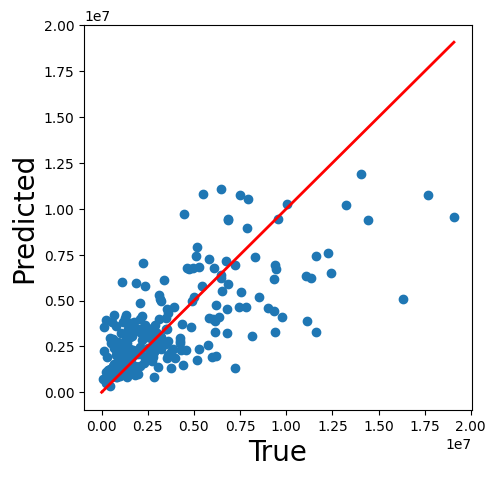

In [44]:
pred_test = best_rf.predict(X_test)
 # Visualisation/évaluation du modèle
plt.figure(figsize=(5,5))
plt.scatter(y_test, pred_test)
plt.plot([0, 12],
         [0, 12],
         color = 'r',
         linestyle = '-',
         linewidth = 2)
plt.ylabel('Predicted', size = 20)
plt.xlabel('True', size = 20)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='r', linestyle='-', linewidth=2)
plt.show()

 Si notre modèle prédisait parfaitement la consommation énergétique des bâtiments, les valeurs prédites seraient égales aux valeurs réelles et se situeraient exactement sur la diagonale roug

### 4.3 Feature importances 

Le model Random forest fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors on utilise  la fonctionnalité feature importance pour **identifier les features les plus impactantes sur la performance du modèle**.

 Sinon, pour d'autres modèles, on aurait utilisé la méthode Permutation Importance de sklearn.

In [45]:
rf_imp = rf.feature_importances_

In [46]:
fxgb_importance = pd.Series(rf_imp, index=X_train_df.columns).nlargest(10)
fxgb_importance 

PropertyGFABuilding(s)           0.449292
pct_electricity                  0.097322
YearBuilt                        0.096630
Longitude                        0.083882
Latitude                         0.067985
PrimaryPropertyType_Warehouse    0.052974
PropertyGFAParking               0.045203
PrimaryPropertyType_Retail       0.041037
NumberofFloors                   0.031472
PrimaryPropertyType_Other        0.015277
dtype: float64

In [47]:
def plot_feature_importance(fxgb_importance):
    """
    Barplot horizontal violet des importances de features.
    fxgb_importance : pd.Series avec index = noms des features, values = importances
    """
    plt.figure(figsize=(11,7))
    
    # Palette violette
    colors = plt.cm.Purples(np.linspace(0.4, 1, len(fxgb_importance)))
    
    bars = plt.barh(
        fxgb_importance.index[::-1],  # inverser pour que la plus importante soit en haut
        fxgb_importance.values[::-1],
        color=colors
    )
    
    # Afficher les valeurs sur les barres
    for bar, val in zip(bars, fxgb_importance.values[::-1]):
        plt.text(
            val + 0.005,  # petit décalage pour le texte
            bar.get_y() + bar.get_height()/2,
            f"{val:.3f}",
            ha='left',
            va='center',
            fontsize=8
        )
    
    plt.xlabel("Importance")
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()

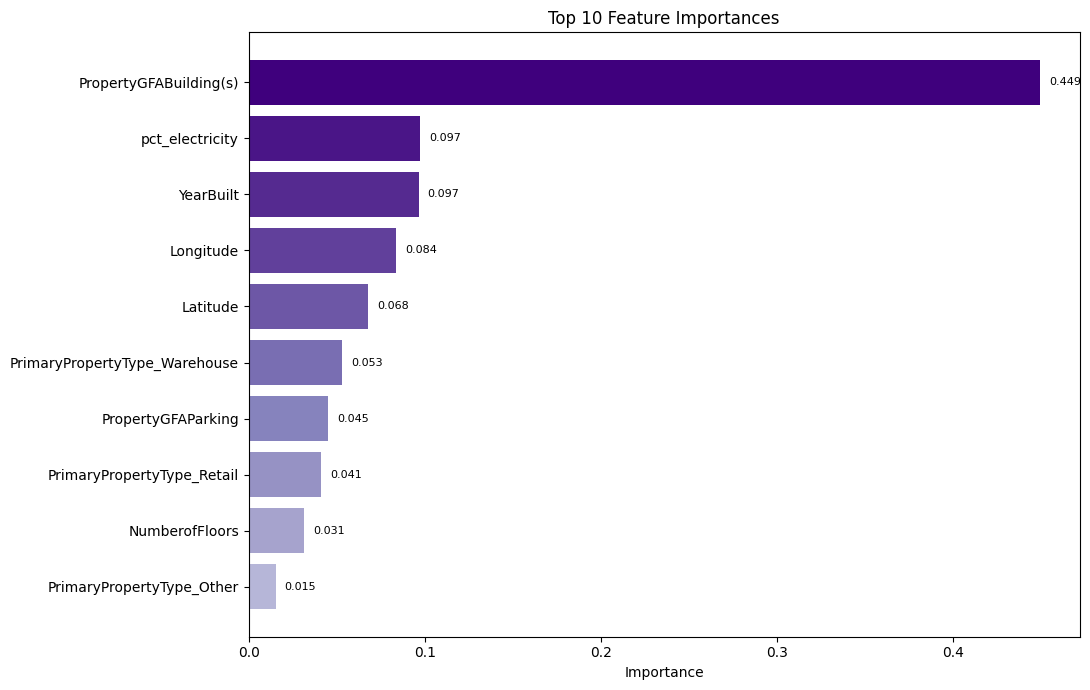

In [48]:
plot_feature_importance(fxgb_importance)

Via la méthode 'feature_importances_' du modèle RandomForest, on peut voir quelles ont été les variables les plus impactantes pour l'entrainement du modèle et pour ses prédictions. On note ici que la variable "surface totale" a un poids bien plus conséquent que les autres. Ensuite, on retrouve "proportion d'électricité utilisée dans le mix énergétique d'un bâtiment" et l'année de construction.

 PropertyGFABuilding(s) : 0.449 → 44,9 % de l’importance totale
→ C’est la feature la plus influente. La taille du bâtiment est de loin le facteur qui impacte le plus la consommation énergétique.

pct_electricity et YearBuilt : environ 9–10 %
→ La proportion d’électricité utilisée et l’année de construction ont un effet significatif mais beaucoup moins que la taille du bâtiment.

### 4.4 Interprétation de l'impact des variables sur le modèle

 Pour savoir dans quels sens ces variables ont influencé la prédiction, nous allons utiliser la librairie SHAP.

In [49]:
shap.initjs

<function shap.plots._force.initjs()>

In [50]:
explainer = shap.Explainer(best_rf)
shap_values = explainer(X_test)

In [51]:
shap_values.feature_names = X_train_df.columns

**Le barplot SHAP = importance moyenne → vue générale.**

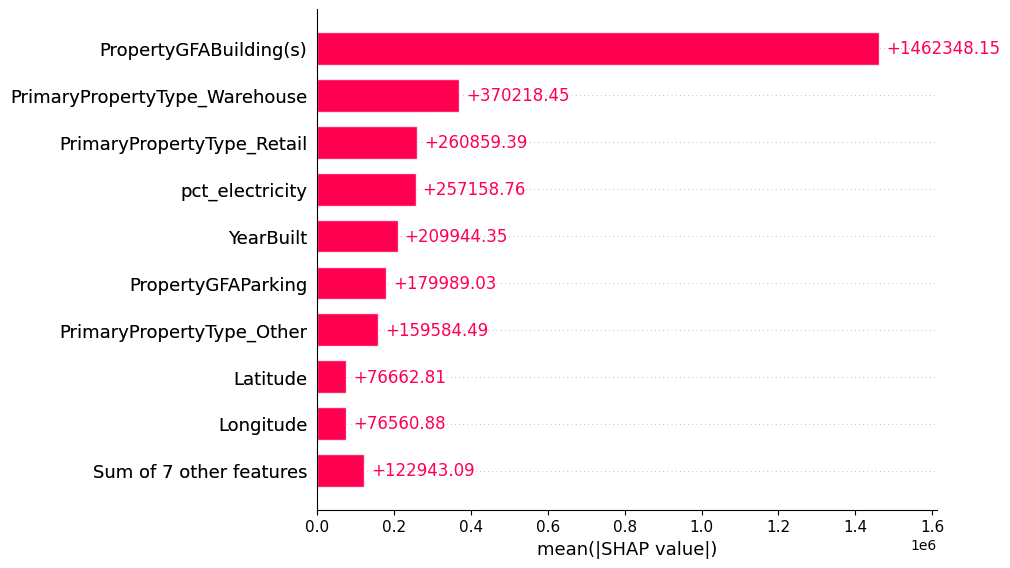

In [52]:

shap.plots.bar(shap_values)

Quand on regarde la moyenne, toutes les variables semblent augmenter la consommation d’énergie. Mais la moyenne ne raconte qu’une partie de l’histoire : elle écrase les différences entre les situations.
Donc on veut aller plus loin et regarder comment chaque variable agit selon les cas — parfois elle augmente la consommation, parfois elle la baisse. C’est pour ça qu’on regarde la distribution des valeurs SHAP, pas seulement leur moyenne.

**Le summary plot SHAP = nuage de points → vue détaillée, point par point.**

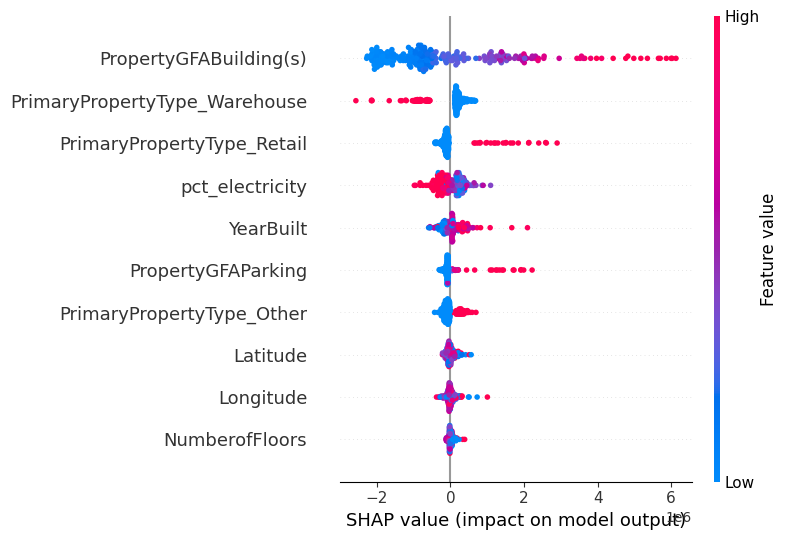

In [53]:
shap.summary_plot(shap_values, max_display=10)

Ce graphique nous permet de déceler les relations existantes entre nos variables et la target.

L’axe X montre l’effet de chaque variable sur la prédiction : plus la valeur est à droite, plus elle augmente la prédiction, et plus elle est à gauche, plus elle la diminue.

La couleur de chaque point sur le graphique représente la valeur de la variable correspondante : le rouge indique des valeurs élevées, le bleu des valeurs faibles.

Si on regarde la variable « surface (GFA) », on voit que lorsque quelle est principalement élevée (rouge), la valeur SHAP est positive. Cela signifie qu’une surface plus élevé a tendance à influencer positivement le résultat.

A l'inverse on voit que plus la proportion d'électricité utilisée dans le mix énergétique d'un bâtiment est élevée, ou que le type d'usage est warehouse et plus la consommation d'énergie prédite sera faible. 

Surprenamment, il  nous apprends que plus le bâtiments est récents, plus il est consommateur d'énergie. (à explorer ! )